### fail이 일어나기 10일전의 데이터 추이를 확인하기 위해 평균을 plot으로 보는 작업

1. remove_null_columns(df), remove_single_value_columns(df) 함수 사용
2. failure disk 데이터들에 대해서, linear interpolate
3. 각 failure disk 별로 고장난 날짜 포함 10일에 대해서,timeseries clustering 하려고 함.
4. 처음 관측된 날짜와 fail이 일어난 날짜와의 차이가 9(10-1)보다 작으면, failure disk에서 제외시킴.
5. fail이 일어나기 이전 9일전 + fail이 일어난 날(총 10일) 데이터를 생성(=to_cluster_data)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
import mglearn

In [6]:
data = pd.read_csv('../../ssd_data/combined_by_diskmodel/combined_MB1.csv',index_col=False)

# 데이터를 시간 순서대로 정렬 ('ds' 컬럼을 기준으로)
data = data.sort_values(by=['ds'])
data = data.drop_duplicates(subset=['disk_id', 'ds'])
data.reset_index(inplace=True)
del(data['index'])
del(data['level_0'])
data

,disk_id,ds,model,n_1,r_1,n_5,r_5,n_9,r_9,n_12,...,r_244,n_245,r_245,n_175,r_175,n_232,r_232,label,n_211,r_211
0,10005,20190101,MB1,NaN,NaN,100.0,0.0,99.0,4600.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
1,39138,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13256.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
2,3918,20190101,MB1,NaN,NaN,100.0,0.0,97.0,13305.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
3,39187,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
4,39189,20190101,MB1,NaN,NaN,100.0,0.0,97.0,12934.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7132648,27627,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132649,27631,20190630,MB1,NaN,NaN,100.0,0.0,96.0,17027.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132650,27676,20190630,MB1,NaN,NaN,100.0,0.0,96.0,18069.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN
7132651,27586,20190630,MB1,NaN,NaN,100.0,0.0,98.0,8476.0,99.0,...,0.0,100.0,65535.0,NaN,NaN,NaN,NaN,0,NaN,NaN


In [7]:
# null값이 있는 열을 제거하는 코드
def remove_null_columns(df):
    # null인 컬럼을 확인하고, 모든 값이 null인 컬럼을 찾습니다.
    null_columns = df.columns[df.isnull().all()]
    
    # 모든 값이 null인 컬럼을 DataFrame에서 제거합니다.
    df = df.drop(null_columns, axis=1)
    
    return df
# 하나의 unique한 값으로만 이루어진 컬럼을 제거하는 코드
def remove_single_value_columns(df):
    single_value_cols = []
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values == 1:
            single_value_cols.append(col)

    df_filtered = df.drop(single_value_cols, axis=1)
    return df_filtered


In [8]:
data = remove_null_columns(data)
data = remove_single_value_columns(data)

failed된 disk_id중에서 첫 관측에서 마지막 관측의 결측치 채우기<br>
interpolate-linear

In [9]:
selected_disk_ids = data[data['label']==1]['disk_id'].unique()

dfs_to_concat = []  # 추가할 데이터프레임들을 저장할 리스트

for disk_id in selected_disk_ids:
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data['ds'] = pd.to_datetime(disk_data['ds'], format='%Y%m%d')
    disk_data = disk_data.sort_values(by='ds')
    disk_data = disk_data.set_index('ds', drop=True)
    all_dates = pd.date_range(start=disk_data.index.min(), end=disk_data.index.max(), freq='D')
    disk_data = disk_data.reindex(all_dates)
    disk_data = disk_data.interpolate(method='linear')
    dfs_to_concat.append(disk_data)

interpolated_data = pd.concat(dfs_to_concat)  # 데이터프레임들을 연결하여 새로운 데이터프레임 생성

interpolated_data = interpolated_data.reset_index()  # 인덱스 재설정
interpolated_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
0,2019-01-01,17909.0,99.0,2.0,97.0,12819.0,99.0,19.0,97.0,155.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.761304e+11,99.0,3.422788e+11,1.0
1,2019-01-02,17909.0,99.0,2.0,97.0,12843.0,99.0,19.0,97.0,155.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.774871e+11,99.0,3.432220e+11,0.0
2,2019-01-03,17909.0,99.0,2.0,97.0,12867.0,99.0,19.0,97.0,156.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.790559e+11,99.0,3.467700e+11,0.0
3,2019-01-04,17909.0,99.0,2.0,97.0,12891.0,99.0,19.0,97.0,156.0,...,32.0,199.0,1.0,100.0,0.0,99.0,4.805626e+11,99.0,3.477830e+11,0.0
4,2019-01-05,17909.0,99.0,2.0,97.0,12915.0,99.0,19.0,97.0,157.0,...,31.0,199.0,1.0,100.0,0.0,99.0,4.819720e+11,99.0,3.512526e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [10]:
selected_disk_model_1 = interpolated_data['disk_id'].unique()

to_delete_id =[]
for disk_id in selected_disk_model_1:
    disk_data = interpolated_data[interpolated_data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    start_index = disk_data.index.min()

    if(failed_index - start_index) < 9:
        to_delete_id.append(disk_id)

# failed_disk_index에 해당하는 행들을 제거
data = interpolated_data[~interpolated_data['disk_id'].isin(to_delete_id)]
data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
1109,2019-01-01,43191.0,100.0,0.0,97.0,13760.0,99.0,22.0,97.0,180.0,...,30.0,200.0,0.0,99.0,8.0,99.0,5.307367e+11,99.0,5.859705e+11,0.0
1110,2019-01-02,43191.0,100.0,0.0,97.0,13784.0,99.0,22.0,97.0,181.0,...,30.0,200.0,0.0,99.0,8.0,99.0,5.318034e+11,99.0,5.889655e+11,0.0
1111,2019-01-03,43191.0,100.0,0.0,97.0,13808.0,99.0,22.0,97.0,181.0,...,30.0,200.0,0.0,99.0,8.0,99.0,5.327934e+11,99.0,5.918898e+11,0.0
1112,2019-01-04,43191.0,100.0,0.0,97.0,13832.0,99.0,22.0,97.0,182.0,...,29.0,200.0,0.0,99.0,8.0,99.0,5.338197e+11,99.0,5.947108e+11,0.0
1113,2019-01-05,43191.0,100.0,0.0,97.0,13856.0,99.0,22.0,97.0,183.0,...,32.0,200.0,0.0,99.0,8.0,99.0,5.349756e+11,99.0,5.975866e+11,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43895,2019-06-26,8599.0,100.0,0.0,96.0,17168.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201000e+12,99.0,8.356453e+11,0.0
43896,2019-06-27,8599.0,100.0,0.0,96.0,17192.0,99.0,21.0,91.0,623.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201312e+12,99.0,8.362658e+11,0.0
43897,2019-06-28,8599.0,100.0,0.0,96.0,17216.0,99.0,21.0,91.0,624.0,...,31.0,200.0,0.0,100.0,0.0,99.0,2.201585e+12,99.0,8.371074e+11,0.0
43898,2019-06-29,8599.0,99.0,2.0,96.0,17240.0,99.0,21.0,91.0,624.0,...,30.0,200.0,0.0,100.0,0.0,99.0,2.201871e+12,99.0,8.379656e+11,0.0


In [11]:
# 라벨이 1인 행을 필터링합니다.
selected_disk_model_1 = data[data['label'] == 1]

# 모델, disk_id, 그리고 날짜 순으로 정렬합니다.
selected_disk_model_1 = selected_disk_model_1.sort_values(by=['disk_id', 'index'])

# disk_id와 model 열만을 선택하여 새로운 데이터 프레임에 저장합니다.
selected_disk_model_1 = selected_disk_model_1[['disk_id']].drop_duplicates().reset_index(drop=True)

# 결과 데이터 프레임을 출력합니다.
selected_disk_model_1.shape

(268, 1)

In [12]:
to_cluster_data = pd.DataFrame()

for disk_id in selected_disk_model_1['disk_id'].unique():
    disk_data = data[data['disk_id'] == disk_id].copy()
    disk_data = disk_data.sort_values(by='index')
    disk_data.reset_index(inplace=True,drop=True)

    failed_index = disk_data[disk_data['label']==1]['index'].index.min()
    before_9day_index = failed_index - 9

    to_cluster = disk_data.iloc[before_9day_index:failed_index+1, :]
    to_cluster_data = pd.concat([to_cluster_data,to_cluster],axis=0)
    
to_cluster_data

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
74,2019-03-16,470.0,99.0,4.0,96.0,16054.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.743607e+09,0.0
75,2019-03-17,470.0,99.0,4.0,96.0,16078.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.744597e+09,0.0
76,2019-03-18,470.0,99.0,4.0,96.0,16102.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.745809e+09,0.0
77,2019-03-19,470.0,99.0,4.0,96.0,16126.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.747037e+09,0.0
78,2019-03-20,470.0,99.0,4.0,96.0,16150.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.748307e+09,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,2019-03-21,44338.0,99.0,2.0,96.0,16176.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.778025e+09,0.0
80,2019-03-22,44338.0,99.0,2.0,96.0,16200.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.779657e+09,0.0
81,2019-03-23,44338.0,99.0,2.0,96.0,16224.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.781085e+09,0.0
82,2019-03-24,44338.0,99.0,2.0,96.0,16248.0,99.0,21.0,99.0,6.0,...,31.0,200.0,0.0,100.0,0.0,99.0,1.352326e+10,99.0,8.782419e+09,0.0


In [13]:
#10일씩 제대로 묶였는지 확인 => ok
to_cluster_data[to_cluster_data['disk_id']==470]

,index,disk_id,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,...,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242,label
74,2019-03-16,470.0,99.0,4.0,96.0,16054.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.743607e+09,0.0
75,2019-03-17,470.0,99.0,4.0,96.0,16078.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.744597e+09,0.0
76,2019-03-18,470.0,99.0,4.0,96.0,16102.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.745809e+09,0.0
77,2019-03-19,470.0,99.0,4.0,96.0,16126.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.747037e+09,0.0
78,2019-03-20,470.0,99.0,4.0,96.0,16150.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.748307e+09,0.0
79,2019-03-21,470.0,99.0,4.0,96.0,16174.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.749580e+09,0.0
80,2019-03-22,470.0,99.0,4.0,96.0,16198.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.750794e+09,0.0
81,2019-03-23,470.0,99.0,4.0,96.0,16222.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.751875e+09,0.0
82,2019-03-24,470.0,99.0,4.0,96.0,16246.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.752874e+09,0.0
83,2019-03-25,470.0,99.0,4.0,96.0,16270.0,99.0,18.0,99.0,7.0,...,29.0,200.0,0.0,100.0,0.0,99.0,1.383236e+10,99.0,8.754062e+09,1.0


In [21]:
mean_data = to_cluster_data.drop(['index','disk_id','label'],axis=1)
mean_data=mean_data.reset_index()
mean_data = mean_data.drop(['index'],axis=1)
mean_data

Index(['n_5', 'r_5', 'n_9', 'r_9', 'n_12', 'r_12', 'n_177', 'r_177', 'n_180',
       'r_180', 'n_181', 'r_181', 'n_182', 'r_182', 'n_183', 'r_183', 'n_184',
       'r_184', 'n_187', 'r_187', 'n_190', 'r_190', 'n_194', 'r_194', 'n_195',
       'r_195', 'n_199', 'r_199', 'n_241', 'r_241', 'n_242', 'r_242'],
      dtype='object')

In [48]:
result = mean_data.groupby(mean_data.index % 10).mean()

# 결과를 출력합니다.
result

,n_5,r_5,n_9,r_9,n_12,r_12,n_177,r_177,n_180,r_180,...,n_194,r_194,n_195,r_195,n_199,r_199,n_241,r_241,n_242,r_242
0,99.660448,5.186567,96.433043,14941.573647,99.0,21.399939,96.500000,216.562076,99.660448,6508.309701,...,70.912153,29.087847,199.242537,857.000000,99.772388,122.272388,98.996269,6.608033e+11,98.992537,4.815164e+11
1,99.492537,16.253731,96.433014,14965.391630,99.0,21.404529,96.496269,216.832768,99.492537,6497.242537,...,70.900275,29.099725,199.242537,857.600746,99.772388,122.272388,98.996269,6.614810e+11,98.992537,4.823825e+11
2,99.447761,18.977612,96.432984,14989.237597,99.0,21.409118,96.492537,217.088535,99.447761,6494.518657,...,70.843622,29.156378,199.242537,857.600746,99.772388,122.272388,98.996269,6.621655e+11,98.992537,4.831193e+11
3,99.425373,20.492537,96.425492,15012.979087,99.0,21.423658,96.491294,217.383480,99.425373,6493.003731,...,70.889581,29.110419,199.242537,857.600746,99.772388,122.284826,98.996269,6.628413e+11,98.992537,4.838193e+11
4,99.391791,21.626866,96.425462,15036.729906,99.0,21.438198,96.482587,217.663501,99.391791,6491.869403,...,70.909420,29.090580,199.242537,857.600746,99.772388,122.297264,98.996269,6.635129e+11,98.992537,4.845259e+11
5,99.373134,22.440299,96.420768,15060.454605,99.0,21.452738,96.470149,217.932327,99.373134,6491.055970,...,70.897542,29.102458,199.238806,857.660448,99.772388,122.309701,98.996269,6.641859e+11,98.992537,4.852809e+11
6,99.356965,23.084577,96.416074,15084.272587,99.0,21.457328,96.462687,218.214213,99.356965,6490.411692,...,70.889397,29.110603,199.238806,857.660448,99.772388,122.320896,98.996269,6.648686e+11,98.992537,4.859953e+11
7,99.329602,23.732587,96.415112,15108.105495,99.0,21.461917,96.458955,218.486771,99.329602,6489.763682,...,70.905504,29.090764,199.233209,857.667910,99.772388,122.343284,98.996269,6.655528e+11,98.992537,4.867329e+11
8,98.779851,26.656716,96.414179,15131.938433,99.0,21.466418,96.451493,218.791045,98.779851,6486.839552,...,70.830224,29.169776,199.216418,857.820896,99.772388,122.354478,98.996269,6.662518e+11,98.992537,4.876639e+11
9,98.604478,35.425373,96.414179,15155.906716,99.0,21.492537,96.451493,218.962687,98.604478,6478.070896,...,70.951493,29.048507,199.167910,864.152985,99.761194,128.070896,98.996269,6.666925e+11,98.992537,4.885192e+11


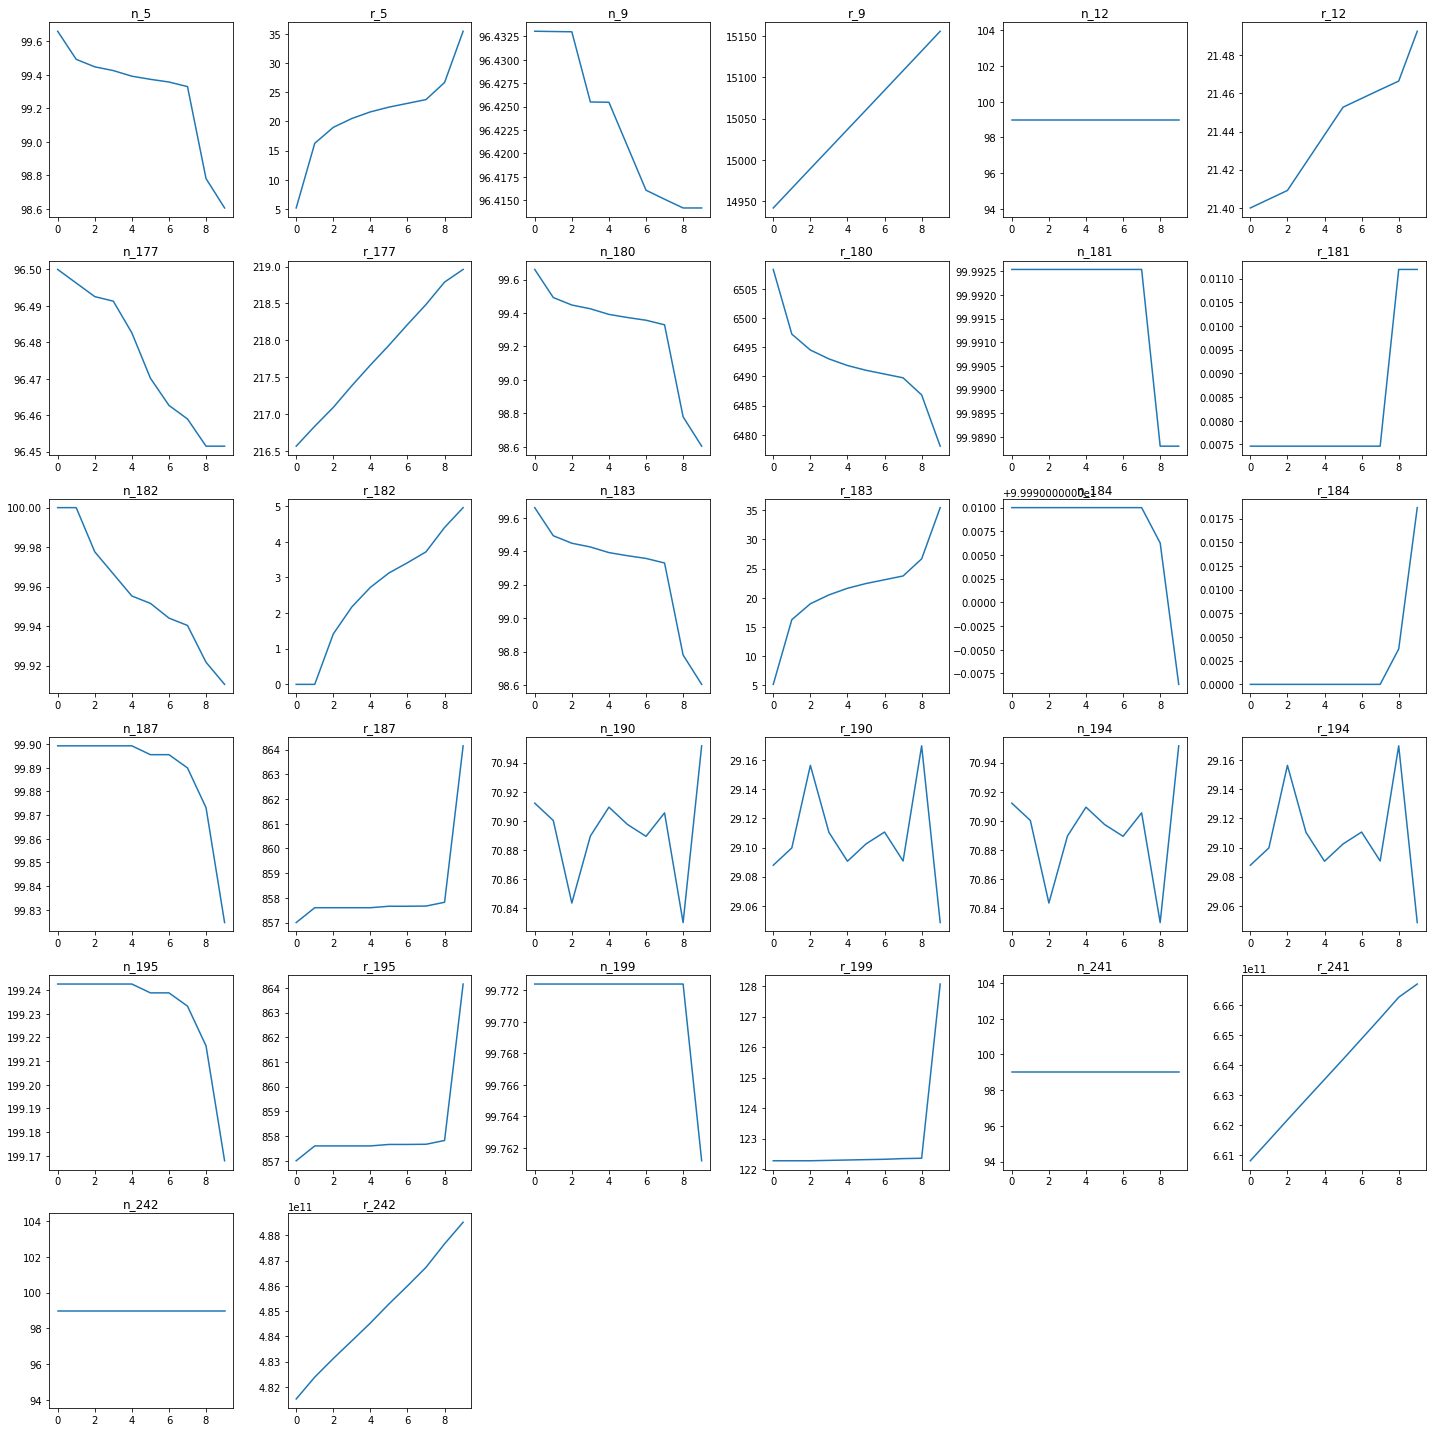

In [49]:
import matplotlib.pyplot as plt
import math

# 전체 subplot의 행과 열의 수를 결정합니다.
n = len(result.columns)
ncols = 6
nrows = math.ceil(n / ncols)

# figsize를 조절하여 그래프의 크기를 조정할 수 있습니다.
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20))

for i, column in enumerate(result.columns):
    # 현재 subplot의 행과 열의 위치를 결정합니다.
    row = i // ncols
    col = i % ncols

    # 해당 위치에 line plot을 그립니다.
    axs[row, col].plot(result[column])
    axs[row, col].set_title(column)

# 남는 subplot이 있을 경우 이를 비활성화합니다.
for i in range(n, nrows*ncols):
    row = i // ncols
    col = i % ncols
    fig.delaxes(axs[row][col])

plt.tight_layout()
plt.show()